In [25]:
import sqlite3
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import LabelEncoder


# **Data Preparation**

## Data Loading

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('data/shop_database.db')

In [4]:
# Read personal_data table
personal_data_query = "SELECT * FROM personal_data"
personal_data = pd.read_sql_query(personal_data_query, conn)
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89241 entries, 0 to 89240
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         89241 non-null  int64 
 1   gender     89241 non-null  int64 
 2   age        89241 non-null  int64 
 3   education  89241 non-null  object
 4   city       89241 non-null  int64 
 5   country    89241 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 4.1+ MB


In [5]:
# Read personal_data_coeffs table
personal_data_coeffs_query = "SELECT * FROM personal_data_coeffs"
personal_data_coeffs = pd.read_sql_query(personal_data_coeffs_query, conn)
personal_data_coeffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   lbt_coef       104989 non-null  float64
 2   ac_coef        104989 non-null  float64
 3   sm_coef        104989 non-null  float64
 4   personal_coef  104989 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


In [6]:
# Read purchases table
purchases_query = "SELECT * FROM purchases"
purchases = pd.read_sql_query(purchases_query, conn)
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [7]:
# Close the database connection
conn.close()

In [8]:
# Read and decompress personal_data.csv.gz
with gzip.open('data/personal_data.csv.gz', 'rt') as f:
    lost_data = pd.read_csv(f)

In [9]:
# Add lost data to personal_data
personal_data = pd.concat([personal_data, lost_data])

In [10]:
# merge all dataframes
data = pd.merge(purchases, personal_data, on='id', how='left')
data = pd.merge(data, personal_data_coeffs, on='id', how='left')

## Data Cleaning and Preprocessing

In [11]:
data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786260 entries, 0 to 786259
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   product        786260 non-null  object 
 2   colour         666736 non-null  object 
 3   cost           786260 non-null  int64  
 4   product_sex    471548 non-null  float64
 5   base_sale      786260 non-null  int64  
 6   dt             786260 non-null  int64  
 7   gender         669956 non-null  float64
 8   age            786260 non-null  int64  
 9   education      786260 non-null  object 
 10  city           786260 non-null  int64  
 11  country        786260 non-null  int64  
 12  lbt_coef       786260 non-null  float64
 13  ac_coef        786260 non-null  float64
 14  sm_coef        786260 non-null  float64
 15  personal_coef  786260 non-null  float64
dtypes: float64(6), int64(7), object(3)
memory usage: 102.0+ MB


The 'product_sex' column contains missing values. We will examine them and decide how to handle them.

In [13]:
data[data['product_sex'].isnull()].head(50)

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
7,4,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,NaN,0,0,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
8,4,Шлем FILA NRK FUN,белый,4999,NaN,0,0,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
9,4,Роликовые коньки детские Roces Yuma TIF,мультицвет,6999,NaN,0,1,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
10,4,Набор защиты из 3-х предметов детский Reaction...,белый/серый,999,NaN,0,1,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
11,4,Шлем для девочек Reaction Urban,розовый,1499,NaN,0,2,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
12,4,Роликовые коньки детские раздвижные Reaction R...,серый/розовый,4399,NaN,0,2,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
13,4,Куртка утепленная для девочек Outventure,None,2999,NaN,0,32,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072


Some product names contain a separation between boys and girls, while others seem to be genderless.
We can use this information to create a feature that will tell us whether the buyer has kids and their kids' gender, but this feature seems to be irrelevant in our case, so we'll just replace missing values with 2.

In [14]:
# replace missing values with '2'
data['product_sex'].replace(to_replace = np.nan, value = 2, inplace = True)

# change data type to int
data['product_sex'] = data['product_sex'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786260 entries, 0 to 786259
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   product        786260 non-null  object 
 2   colour         666736 non-null  object 
 3   cost           786260 non-null  int64  
 4   product_sex    786260 non-null  int32  
 5   base_sale      786260 non-null  int64  
 6   dt             786260 non-null  int64  
 7   gender         669956 non-null  float64
 8   age            786260 non-null  int64  
 9   education      786260 non-null  object 
 10  city           786260 non-null  int64  
 11  country        786260 non-null  int64  
 12  lbt_coef       786260 non-null  float64
 13  ac_coef        786260 non-null  float64
 14  sm_coef        786260 non-null  float64
 15  personal_coef  786260 non-null  float64
dtypes: float64(5), int32(1), int64(7), object(3)
memory usage: 99.0+ MB


Now, let's address the 'coulors' column.

In [15]:
# replace missing values in purchases['colour'] witn 'неизвестно'
data['colour'].fillna('неизвестно', inplace=True)

# create set of all the colours
colours = set()

for colour in data['colour']:
    for c in colour.split('/'):
        colours.add(c.strip())
print(len(colours))

colours

362


{'BG',
 'BGH',
 'C',
 'CB',
 'CH',
 'DBP',
 'FT',
 'FTGPK',
 'G',
 'GAU',
 'GSU',
 'HPS',
 'HT',
 'HTPK',
 'INC',
 'MBT',
 'PEHL',
 'PEL',
 'PK',
 'PWRT',
 'RBS',
 'ROL',
 'S',
 'SB',
 'TR',
 'cеребряный',
 'Бежевый',
 'Белый',
 'Голубой',
 'Желтый',
 'Зеленый',
 'Коричневый',
 'Красный',
 'Лимонный',
 'Мультицвет',
 'Оранжевый',
 'Разноцветный',
 'Розовый',
 'Серебряный',
 'Серый',
 'Синий',
 'Тёмно-голубой',
 'Фиолетовый',
 'Черный',
 'абрикосовый',
 'авокадо',
 'аквамарин',
 'алый',
 'антрацит',
 'антрацитовый',
 'асфальтовый',
 'бeлый',
 'баклажановый',
 'бежевый',
 'бело-розовый',
 'бело-серый',
 'бело-черный',
 'белый',
 'бесцветный',
 'бирюзово-бежевый',
 'бирюзовый',
 'бледно-белый',
 'бледно-голубой',
 'бледно-зеленый',
 'бледно-мятный',
 'бледно-розовый',
 'бледно-сиреневый',
 'болотный',
 'бордо',
 'бордово-коричневый',
 'бордовый',
 'бронзовый',
 'бургунди',
 'варио',
 'васильковый',
 'вереск',
 'винный',
 'виноградный',
 'вишневый',
 'вишнёвый',
 'водно-зеленый',
 'волна',

Colours column contains abbreviations of colours. We will replace them with full names.

In [16]:
# create a dictionary of transcripts

transcripts = {
    'FTGPK': 'Фуксия/розовый',
    'PWRT': 'Белый/красный',
    'PEHL': 'Персиковый/хаки/лимонный',
    'HTPK': 'Хаки/розовый',
    'BGH': 'Бежево-серый',
    'DBP': 'Темно-сине-пурпурный',
    'GAU': 'Золотой',
    'GSU': 'Зелено-серебряный',
    'HPS': 'Светло-розовый',
    'INC': 'Индиго',
    'MBT': 'Горчично-коричневый',
    'PEL': 'Бледно-лавандовый',
    'RBS': 'Сине-серебряный',
    'ROL': 'Розово-лиловый',
    'BG':'Бежевый',
    'CB': 'Кобальтово-синий',
    'CH': 'Угольно-черный',
    'SB': 'Небесно-голубой',
    'FT': 'Фуксия',
    'HT': 'Хаки',
    'TR': 'Бирюзовый',
    'PK': 'Розовый',
    'C': 'Голубой',
    'S': 'Серебряный',
    'G': 'Зеленый'
}

for key, value in transcripts.items():
    data['colour'] = data['colour'].str.replace(key, value)
    

In [17]:
# replace '-' with '/' split by '/' and lowercase
data['colour'] = data['colour'].str.lower()
data['colour'] = data['colour'].str.replace('-', '/')
data['colour'] = data['colour'].str.split('/')
data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""","[белый, синий]",13599,0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,Стол Outventure,[зелёный],1499,2,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,[бежевый],4799,2,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,Бутсы мужские GSD Astro,[белый],1599,1,0,13,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,[мультицвет],7199,2,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [18]:
# create a dictionary of misspelled colours

color_mapping = {
    'антрацит': 'антрацитовый',
    'бeлый': 'белый',
    'винный': 'виноградный',
    'вишнёвый': 'вишневый',
    'графит': 'графитовый',
    'жёлтый': 'желтый',
    'зелёный': 'зеленый',
    'золотистый': 'золотой',
    'ирис': 'ирисовый',
    'яблоко': 'яблочный',
    'хром': 'хромовый',
    'сиинй': 'синий',
    'серовато': 'серый',
    'cеребряный': 'серебряный',
    'серебристый': 'серебряный',
    'серебро': 'серебряный',
    'св.розовый': 'розовый',
    'неопределённый': 'неизвестный',
    'многоцветный': 'цветной',
    'мультицвет': 'цветной',
    'мультиколор': 'цветной',
    'разноцветный': 'цветной',
    'персик': 'персиковый',
    'нюд': 'нюдовый',
    'металлик': 'металлический',
    'леопард': 'леопардовый',
    'лайм': 'лаймовый',
    'коралл': 'коралловый',
    'клетка': 'клетчатый',
    'камуфляж': 'камуфляжный',
    'какао': 'кофейный',
}

# replace misspelled colors with correct ones
purchases_sp = data.copy()
for i, colour in enumerate(purchases_sp['colour']):
    for j, c in enumerate(colour):
        if c in color_mapping:
            purchases_sp['colour'][i][j] = color_mapping[c]

Now let's cut off the endings.

In [19]:
from nltk.stem import SnowballStemmer

# Create a stemmer
stemmer = SnowballStemmer('russian')

# Stem words
data['colour'] = data['colour'].apply(lambda x: [stemmer.stem(y) for y in x])

data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""","[бел, син]",13599,0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,Стол Outventure,[зелен],1499,2,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,[бежев],4799,2,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,Бутсы мужские GSD Astro,[бел],1599,1,0,13,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,[цветн],7199,2,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [20]:
# let's look at the result
colours = set()

for colour in data['colour']:
    for c in colour:
        colours.add(c)
print(len(colours))

colours

166


{'абрикосов',
 'авокад',
 'аквамарин',
 'ал',
 'антрацитов',
 'асфальтов',
 'баклажанов',
 'бежев',
 'бел',
 'бесцветн',
 'бирюзов',
 'бледн',
 'болотн',
 'борд',
 'бордов',
 'бронзов',
 'бургунд',
 'вар',
 'васильков',
 'вереск',
 'виноградн',
 'вишнев',
 'водн',
 'волн',
 'вольт',
 'глинян',
 'глянцев',
 'голуб',
 'горчичн',
 'гранитн',
 'графитов',
 'грязн',
 'да',
 'дерев',
 'джунгл',
 'дымчат',
 'ежевичн',
 'елов',
 'желт',
 'жемчужн',
 'зебр',
 'зел',
 'зелен',
 'зеркальн',
 'золот',
 'изумрудн',
 'индиг',
 'ирисов',
 'кам',
 'камуфляжн',
 'карбон',
 'каштанов',
 'кедров',
 'кирпичн',
 'кислотн',
 'клетчат',
 'клубник',
 'кобальтов',
 'кораллов',
 'коричнев',
 'кост',
 'кофейн',
 'красн',
 'кремов',
 'кукурузн',
 'лавандов',
 'лазурн',
 'лаймов',
 'латт',
 'латун',
 'леопардов',
 'лилов',
 'лимон',
 'лососев',
 'льнян',
 'маджент',
 'малахитов',
 'малинов',
 'манг',
 'масля',
 'матов',
 'медн',
 'медов',
 'мел',
 'меланж',
 'ментол',
 'металлическ',
 'милитар',
 'молочн',
 'морко

We've cut the number of unique colors in half!

In [21]:
# Create dummy variables for each colour
# Extract and clean the color information
data['colour'] = data['colour'].astype(str)
data['colour'] = data['colour'].str.strip('[]').str.replace(' ', '')

# Split the colour column using commas as delimiters and create dummy variables
color_dummies = data['colour'].str.get_dummies(',')

# Concatenate the dummy variables with the original DataFrame
data = pd.concat([data, color_dummies], axis=1)

# Drop the colour column
data.drop('colour', axis=1, inplace=True)
data.head()


,id,product,cost,product_sex,base_sale,dt,gender,age,education,city,...,'циа','черн','черничн','шампан','шторм','экр','яблочн','ягодн','янтарн','ярк'
0,0,"Велосипед горный женский Stern Mira 2.0 26""",13599,0,1,7,0.0,36,среднее,1201,...,0,0,0,0,0,0,0,0,0,0
1,0,Стол Outventure,1499,2,0,37,0.0,36,среднее,1201,...,0,0,0,0,0,0,0,0,0,0
2,0,Набор Outventure: стол + 4 стула,4799,2,0,37,0.0,36,среднее,1201,...,0,0,0,0,0,0,0,0,0,0
3,3,Бутсы мужские GSD Astro,1599,1,0,13,NaN,31,среднее,1134,...,0,0,0,0,0,0,0,0,0,0
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,7199,2,0,27,NaN,31,среднее,1134,...,0,0,0,0,0,0,0,0,0,0


In [22]:
data.education.value_counts()

среднее    629076
высшее     157184
Name: education, dtype: int64

In [23]:
# Encode the 'education' column
label_encoder = LabelEncoder()

data['education'] = label_encoder.fit_transform(data['education'])
data.head()

,id,product,cost,product_sex,base_sale,dt,gender,age,education,city,...,'циа','черн','черничн','шампан','шторм','экр','яблочн','ягодн','янтарн','ярк'
0,0,"Велосипед горный женский Stern Mira 2.0 26""",13599,0,1,7,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
1,0,Стол Outventure,1499,2,0,37,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
2,0,Набор Outventure: стол + 4 стула,4799,2,0,37,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
3,3,Бутсы мужские GSD Astro,1599,1,0,13,NaN,31,1,1134,...,0,0,0,0,0,0,0,0,0,0
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,7199,2,0,27,NaN,31,1,1134,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df = data.copy()
suffixes = ('ый', 'ие', 'ий', 'ой', 'ее', 'ые', 'ая')

def clean_text(text):
    # Convert to lowercase, remove symbols except Russian letters, and strip spaces
    text = re.sub(r'[^а-я\s]', '', text.lower()).strip()
    # Split into words
    words = text.split()
    # Filter out words with suffixes
    text = ' '.join([word for word in words if not word.endswith(suffixes)])
    # Keep only the first word
    if len(text.split()) > 0:
        text = text.split()[0]
    return text

# Clean the 'product' column
df['product'] = df['product'].apply(clean_text)
df.head()

,id,product,cost,product_sex,base_sale,dt,gender,age,education,city,...,'циа','черн','черничн','шампан','шторм','экр','яблочн','ягодн','янтарн','ярк'
0,0,велосипед,13599,0,1,7,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
1,0,стол,1499,2,0,37,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
2,0,набор,4799,2,0,37,0.0,36,1,1201,...,0,0,0,0,0,0,0,0,0,0
3,3,бутсы,1599,1,0,13,NaN,31,1,1134,...,0,0,0,0,0,0,0,0,0,0
4,3,мяч,7199,2,0,27,NaN,31,1,1134,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786255,178004,полуботинки,7999,1,0,12,1.0,52,0,1188,...,0,1,0,0,0,0,0,0,0,0
786256,178004,кроссовки,24299,1,0,13,1.0,52,0,1188,...,0,1,0,0,0,0,0,0,0,0
786257,178004,кроссовки,24299,1,0,20,1.0,52,0,1188,...,0,1,0,0,0,0,0,0,0,0
786258,178004,пакет,12,2,0,20,1.0,52,0,1188,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df['product'].value_counts()[:200]

KeyError: 'product'

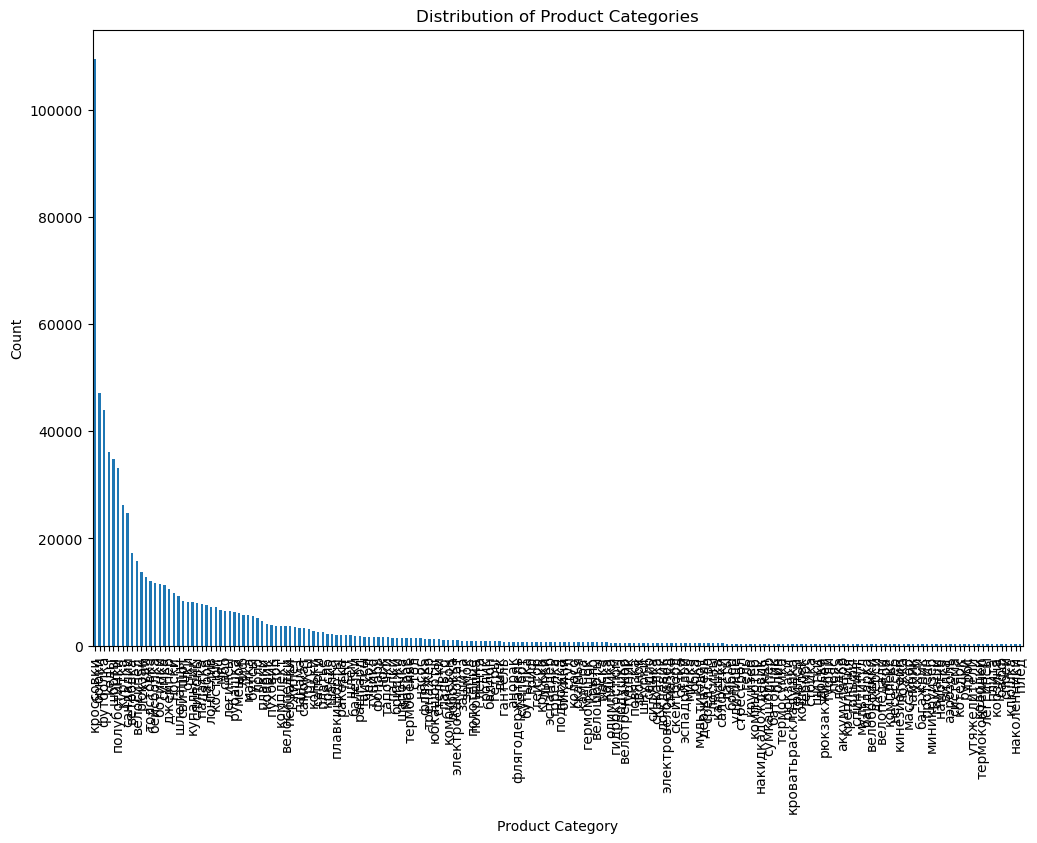

In [47]:
# Plot the distribution of product categories limited to the top 200
plt.figure(figsize=(12, 8))
df['product'].value_counts()[:200].plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()

In [48]:
# Create dummy variables for top 200 product categories
product_dummies = df['product'].value_counts()[:200].index
product_dummies = df['product'].apply(lambda x: x if x in product_dummies else np.nan)
product_dummies = pd.get_dummies(product_dummies)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, product_dummies], axis=1)

# Drop the product column
df.drop('product', axis=1, inplace=True)
df.head()

,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,...,шлепанцы,шнурки,шорты,щитки,электровелосипед,электросамокат,эспадрильи,эспандер,юбка,юбкашорты
0,0,13599,0,1,7,0.0,36,1,1201,32,...,0,0,0,0,0,0,0,0,0,0
1,0,1499,2,0,37,0.0,36,1,1201,32,...,0,0,0,0,0,0,0,0,0,0
2,0,4799,2,0,37,0.0,36,1,1201,32,...,0,0,0,0,0,0,0,0,0,0
3,3,1599,1,0,13,NaN,31,1,1134,32,...,0,0,0,0,0,0,0,0,0,0
4,3,7199,2,0,27,NaN,31,1,1134,32,...,0,0,0,0,0,0,0,0,0,0
